In [1]:
import glob, pdb

import numpy as np
from sklearn.linear_model import Lasso
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pysindy.feature_library import IdentityLibrary
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import Counter
from scipy.optimize import minimize

In [3]:
def format_rp_rd(rp,rd):
    if rp==int(rp):
        rp = int(rp)
    else:
        rp = round(rp,2)
    rd = rp/2;
    if rd==int(rd):
        rd = int(rd)
    else:
        rd = round(rd,3)
    return rp,rd

def BDM_RHS(t, C, Pp, coefs, param_degree=1, C_degree = 4):
    
    assert type(param_degree) in [int,np.ndarray], "param_degree must be int or np.ndarray"
    assert type(C_degree) in [int,np.ndarray], "C_degree must be int or np.ndarray"
    assert type(C_degree) == type(param_degree), "types of param_degree and C_degree must match"
    
    if type(param_degree) == int:
    
        p_deg_mesh, C_deg_mesh = np.meshgrid(np.arange(1,param_degree+1),
                                             np.arange(1,C_degree+1),
                                             indexing = "ij")
        
        features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(p_deg_mesh.reshape(-1),
                                                                C_deg_mesh.reshape(-1))] #+ [Pp**2*(C**p) for p in np.arange(1,deg+1)]
    
    elif type(param_degree) == np.ndarray:
        
        features = [(Pp**pdeg)*(C**cdeg) for (pdeg,cdeg) in zip(param_degree,C_degree)] 
        
    X = np.array(features).T

    return np.matmul(X,coefs[0])

def forward_solve(t, IC, Pp, coefficients, param_degree=1, C_degree = 4):
    t_solve_span = (t[0], t[-1])

    return solve_ivp(
                      BDM_RHS, t_solve_span, IC, t_eval=t,
                        args = (Pp,coefficients,param_degree, C_degree)
                      ).y.T

def tensor_data_build(files):
    
    #initialize tensor
    Cds = []
    #time arrays
    ts = []
    #Pps
    Pps = []
    
    for file in files:

        mat = np.load(file,allow_pickle=True).item()

        C_ = mat['variables'][1]
        Ct_ = mat['variables'][2]
        t_ = mat['variables'][0]

        Pp_ = float(mat['rp'][0][0])
        Pd_ = float(mat['rd'][0][0])
        Pm_ = float(mat['rm'][0][0])
        
        Cds.append(C_[:,0])
        ts.append(t_[:,0])
        Pps.append(Pp_)

    Cds = np.array(Cds)
    
    return Cds, ts, Pps

def tensor_model_build(Cds,ts,Pps,coefficients,param_degree=1,C_degree=4):
    
    Cms = []
    for Cd,t,Pp in zip(Cds, ts, Pps):
        
        IC = Cd[0,None] #IC must be 1d; cannot be a scalar
        Cm = forward_solve(t,IC,Pp,coefficients,param_degree,C_degree)
        Cms.append(Cm[:,0])

    if np.all([len(Cm) == len(ts[0]) for Cm in Cms]):
        ## All arrays of the same size
        Cms = np.array(Cms)
    else:
        ## If one or more solutions are of different size, return 1e10
        Cms = 1e10*np.ones((len(Pps),len(ts[0])))
    
    return Cms

def MSE(a,b):
    """
    Calculate the mean squared error between two arrays.

    Args:
        a (numpy.ndarray): The first array.
        b (numpy.ndarray): The second array.

    Returns:
        float: The mean squared error between `a` and `b`.
    """
    assert a.shape == b.shape
    return ((a - b)**2).mean()  

def print_DE(xi,learned_param_degrees,learned_C_degrees):
    DE_list = [f"{round(x,2)}*P_p^{pdeg}*C^{cdeg}" for (x,pdeg,cdeg) in zip(xi,learned_param_degrees,learned_C_degrees)]
    DE_str = DE_list[0]

    for x,term in zip(xi[1:],DE_list[1:]):
        if x < 0:
            DE_str += (" - " + term[1:])
        else:
            DE_str += (" + " + term)

    print(DE_str)
    return(DE_str)


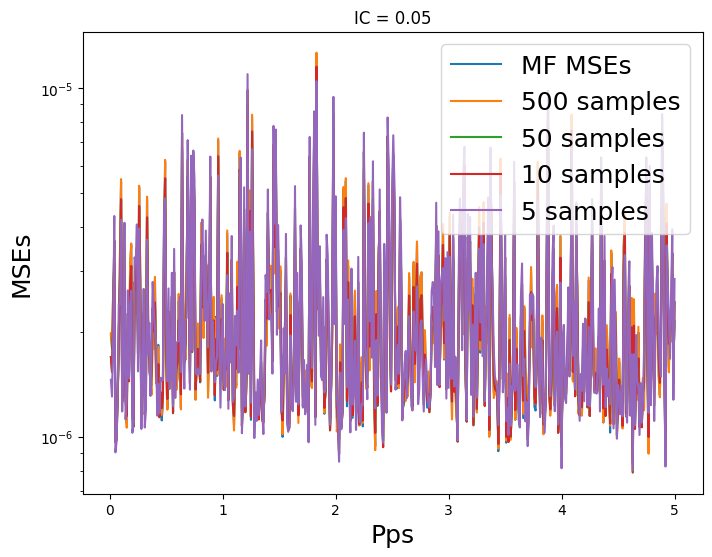

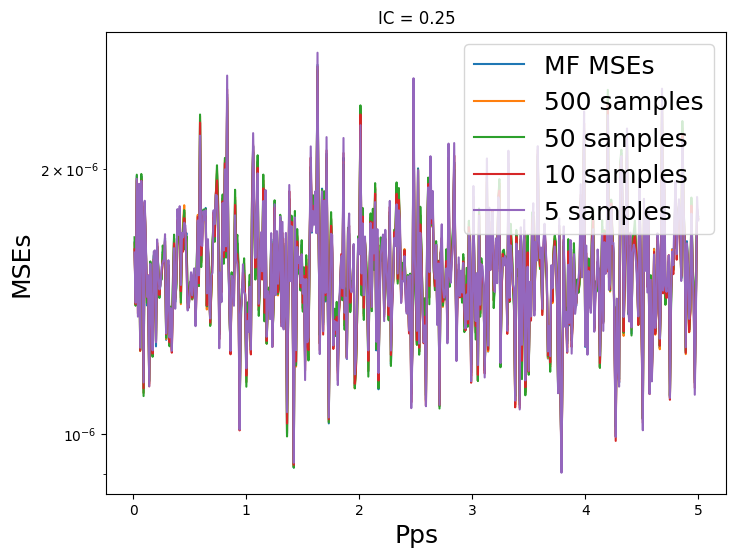

In [10]:
data_type = "mean_field_lessnoise"#"ABM"#,"mean_field_nonoise","mean_field_lessnoise"

param_degree = 1
C_degree = 10

fontsize = 18

ICs = [0.05, 0.25]
drps = [0.01, 0.1, 0.5, 1]

for IC in ICs:

    ### Get all data
    if data_type == "ABM":
        allFiles = glob.glob(f"../../data/ABM/*m_{IC}*.npy")
    elif "mean_field" in data_type:
        allFiles = glob.glob(f"../../data/Data_{data_type}/*m_{IC}*.npy")
    allFiles.sort()

    CDs, ts, Pps = tensor_data_build(allFiles)

    Pps.sort()

    MFs = tensor_model_build(CDs,ts,Pps,[np.array([0.5,-1])],
                np.array([1,1]),np.array([1,2]))

    MF_MSEs = []
    for i in range(len(Pps)):
        MF_MSEs.append(MSE(CDs[i,:], MFs[i,:]))
    MF_MSEs = np.array(MF_MSEs)

    plt.figure(figsize=(8,6))
    plt.semilogy(Pps, MF_MSEs, label = "MF MSEs")

    for drp in drps:

        mat = np.load(f"../../results/ES-MEEQL/learned_coeffs_{data_type}_param_degree_{param_degree}_C_degree_{C_degree}_IC_{IC}_drp_{drp}.npy",
                     allow_pickle=True).item()

        xi = mat["xi"]
        learned_C_degrees = mat["learned_C_degrees"]
        learned_param_degrees = mat["learned_param_degrees"]

        CMs = tensor_model_build(CDs,ts,Pps,[xi],
                learned_param_degrees,learned_C_degrees)

        learned_MSEs = []
        for i in range(len(Pps)):
            learned_MSEs.append(MSE(CDs[i,:], CMs[i,:]))
        learned_MSEs = np.array(learned_MSEs)

        num_samples = int(5/drp)

        plt.semilogy(Pps, learned_MSEs, label = f"{num_samples} samples")
    plt.legend(fontsize=fontsize)
    plt.title(f"IC = {IC}")
    plt.xlabel(f"Pps",fontsize=fontsize)
    plt.ylabel(f"MSEs",fontsize=fontsize)

    plt.savefig(f"MSEs_{data_type}_IC_{IC}.png")

In [18]:
ICs = [0.05, 0.25]
drps = [0.01, 0.5, 1]

data_type = "ABM"

for IC in ICs:
    print(f"IC = {IC}\n")
        
    for drp in drps:

        mat = np.load(f"../../results/ES-MEEQL/learned_coeffs_{data_type}_param_degree_{param_degree}_C_degree_{C_degree}_IC_{IC}_drp_{drp}.npy",
                     allow_pickle=True).item()

        xi = mat["xi"]
        learned_C_degrees = mat["learned_C_degrees"]
        learned_param_degrees = mat["learned_param_degrees"]

        num_samples = int(5/drp)
        
        print(f"{num_samples} samples:")
        print_DE(xi,learned_param_degrees,learned_C_degrees)
        print("")
        
        

IC = 0.05

500 samples:
0.36*P_p^1*C^1 - 2.35*P_p^1*C^2 + 5.65*P_p^1*C^3 - 5.09*P_p^1*C^4

10 samples:
0.4*P_p^1*C^1 - 2.53*P_p^1*C^2 + 5.81*P_p^1*C^3 - 4.92*P_p^1*C^4

5 samples:
0.42*P_p^1*C^1 - 2.37*P_p^1*C^2 + 3.92*P_p^1*C^3 - 3.84*P_p^1*C^5

IC = 0.25

500 samples:
0.34*P_p^1*C^1 - 0.85*P_p^1*C^2

10 samples:
0.85*P_p^1*C^1 - 2.95*P_p^1*C^2 + 5.24*P_p^1*C^4

5 samples:
0.86*P_p^1*C^1 - 2.92*P_p^1*C^2 + 4.94*P_p^1*C^4



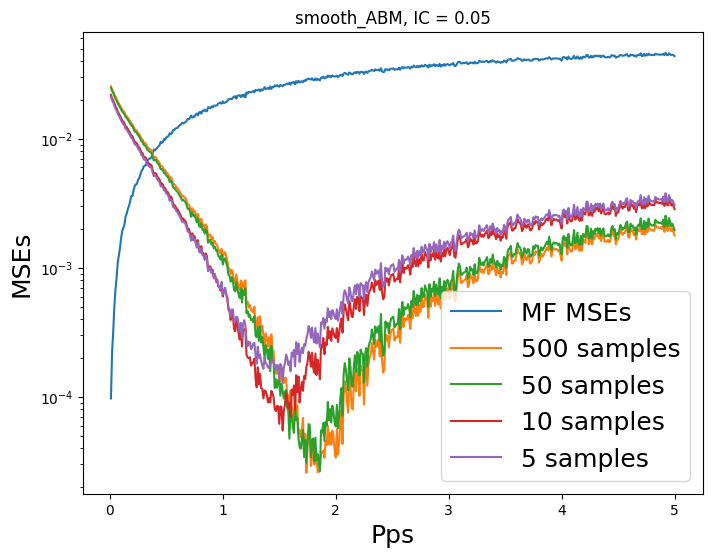

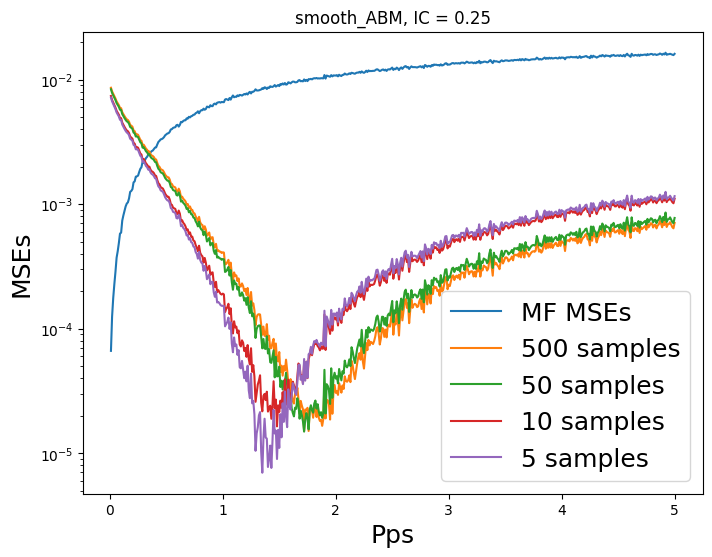

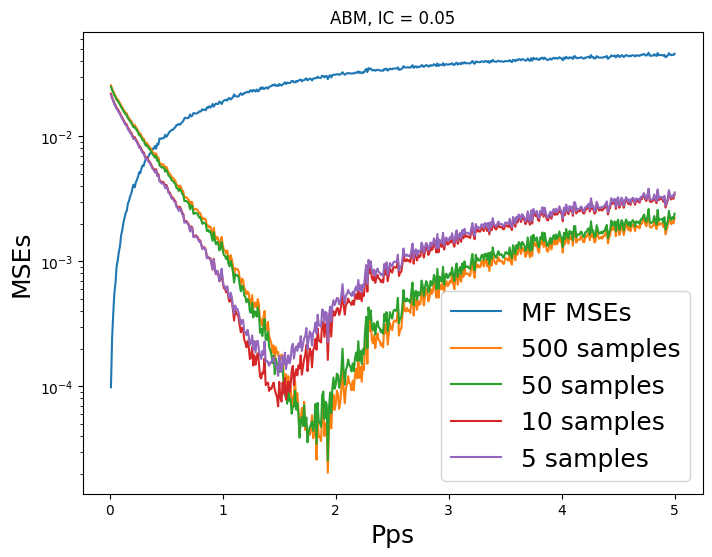

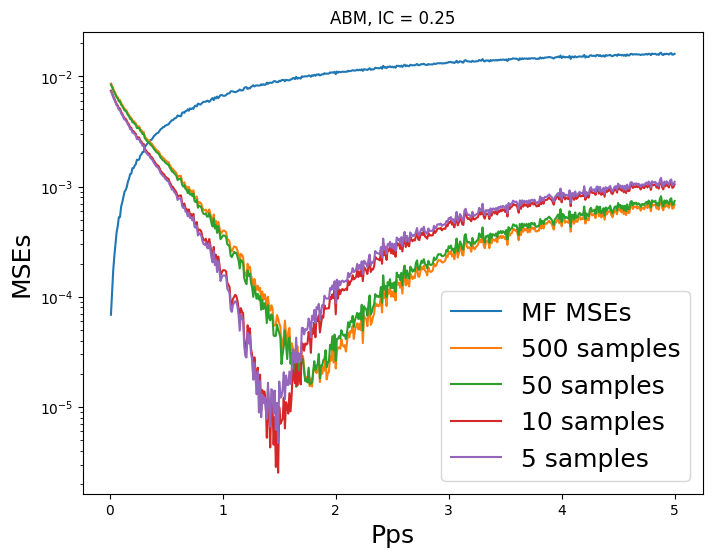

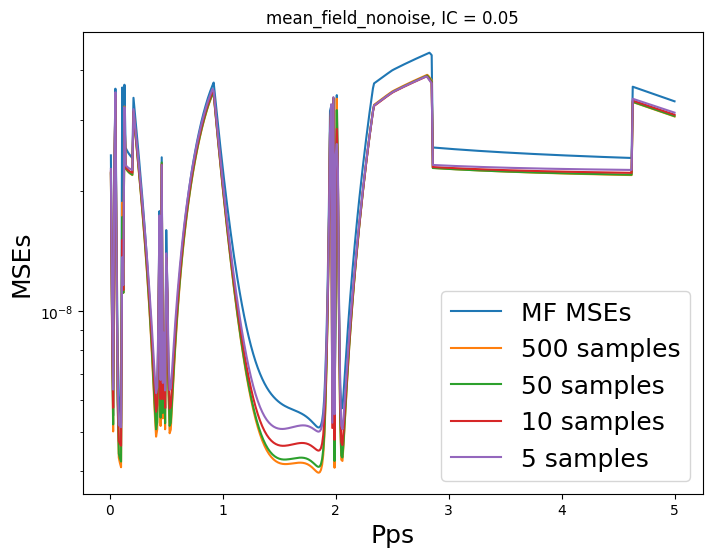

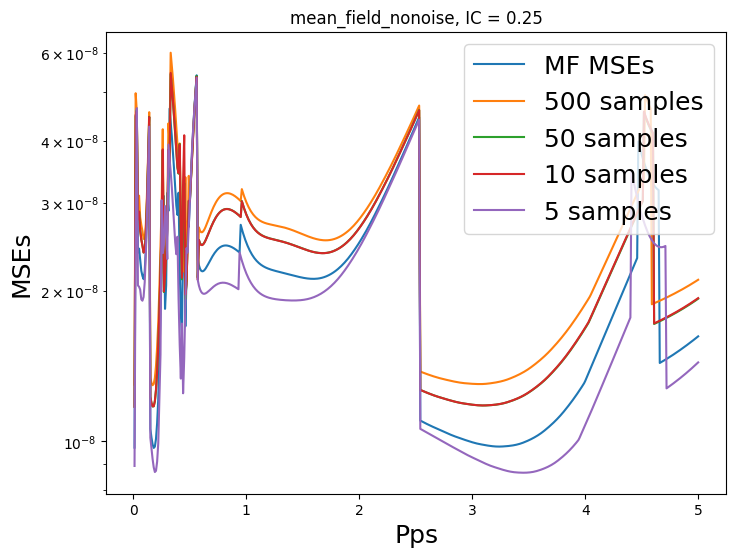

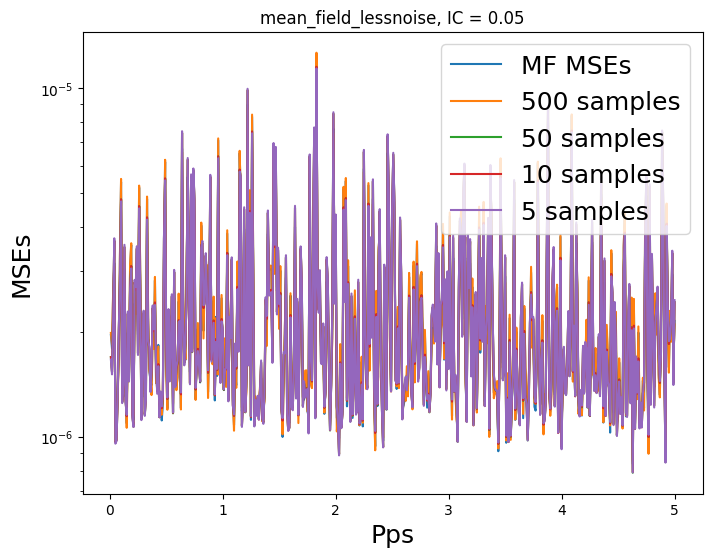

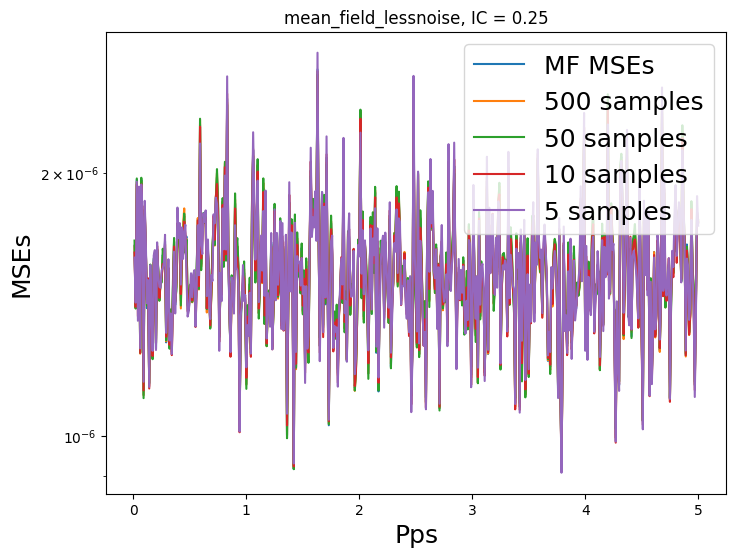

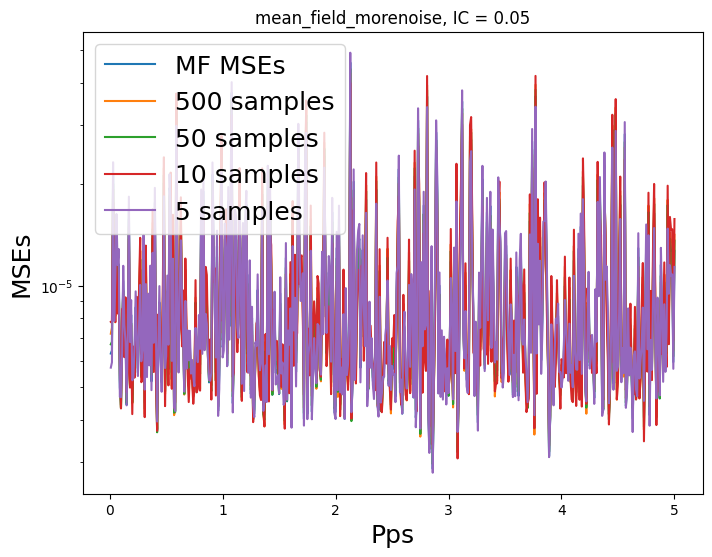

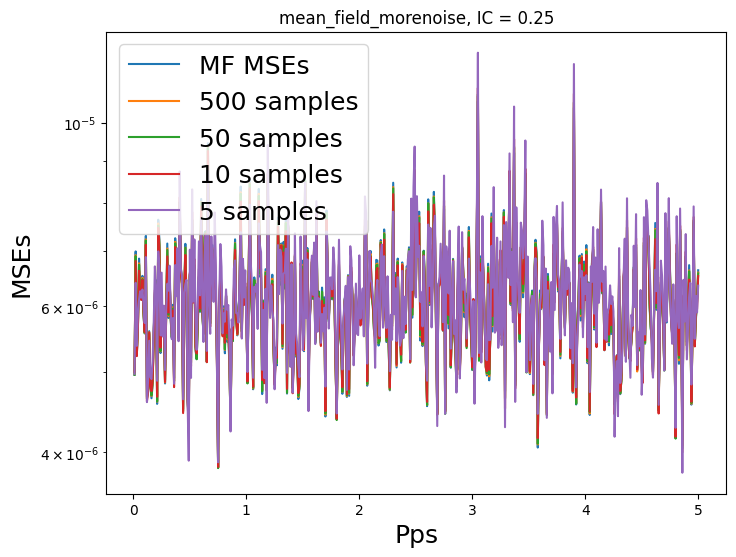

In [7]:
data_types = ["ABM",
              "mean_field_nonoise",
              "mean_field_lessnoise"]

param_degree = 1
C_degree = 10
fontsize = 18

all_MSEs = {}
drps = [0.01, 0.5, 1]

for data_type in data_types:

    all_MSEs[data_type] = {}
    
    ICs = [0.05, 0.25]

    for IC in ICs:

        all_MSEs[data_type][IC] = {}
        
        ### Get all data
        if data_type == "ABM":
            allFiles = glob.glob(f"../../data/ABM/*m_{IC}*.npy")
        elif "mean_field" in data_type:
            allFiles = glob.glob(f"../../data/Data_{data_type}/*m_{IC}*.npy")
        allFiles.sort()
        
        CDs, ts, Pps = tensor_data_build(allFiles)

        Pps.sort()

        MFs = tensor_model_build(CDs,ts,Pps,[np.array([0.5,-1])],
                    np.array([1,1]),np.array([1,2]))

        MF_MSEs = []
        for i in range(len(Pps)):
            MF_MSEs.append(MSE(CDs[i,:], MFs[i,:]))
        MF_MSEs = np.array(MF_MSEs)

        plt.figure(figsize=(8,6))
        plt.semilogy(Pps, MF_MSEs, label = "MF MSEs")
        all_MSEs[data_type][IC]["mean_field"] = MF_MSEs
        
        for drp in drps:

            mat = np.load(f"learned_coeffs_{data_type}_param_degree_{param_degree}_C_degree_{C_degree}_IC_{IC}_drp_{drp}.npy",
                         allow_pickle=True).item()

            xi = mat["xi"]
            learned_C_degrees = mat["learned_C_degrees"]
            learned_param_degrees = mat["learned_param_degrees"]

            CMs = tensor_model_build(CDs,ts,Pps,[xi],
                    learned_param_degrees,learned_C_degrees)

            learned_MSEs = []
            for i in range(len(Pps)):
                learned_MSEs.append(MSE(CDs[i,:], CMs[i,:]))
            learned_MSEs = np.array(learned_MSEs)

            num_samples = int(5/drp)

            all_MSEs[data_type][IC][num_samples] = learned_MSEs
            
            plt.semilogy(Pps, learned_MSEs, label = f"{num_samples} samples")
        plt.legend(fontsize=fontsize)
        plt.title(f"{data_type}, IC = {IC}")
        plt.xlabel(f"Pps",fontsize=fontsize)
        plt.ylabel(f"MSEs",fontsize=fontsize)

        plt.savefig(f"MSEs_{data_type}_IC_{IC}_param_degree_{param_degree}_C_degree_{C_degree}.png")

np.save(f"learned_MSEs_param_degree_{param_degree}_C_degree_{C_degree}.npy",all_MSEs)

In [16]:
all_MSEs.keys()

dict_keys(['smooth_ABM', 'ABM', 'mean_field_nonoise', 'mean_field_lessnoise', 'mean_field_morenoise'])

In [21]:
len(all_MSEs["smooth_ABM"][0.05][5])

500